# CycleGAN
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os

In [14]:
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torch.nn.functional as F

## Load and Visualize the Data

In [3]:
def get_dataloader(image_type, image_path='../../data/summer2winter_yosemite',
                   image_size=128, batch_size=16):
    '''
    Create and return train and test dataloaders
    '''
    transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.ToTensor()])
    # path to the train and test images
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, f'test_{image_type}')
    
    train_dataset = datasets.ImageFolder(train_path, transform=transform)
    test_dataset = datasets.ImageFolder(test_path, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

In [4]:
train_X, test_X = get_dataloader('summer')
train_Y, test_Y = get_dataloader('winter')

#### Display some images

In [5]:
X_iter, Y_iter = iter(train_X), iter(train_Y)

images_X, _ = next(X_iter)
images_Y, _ = next(Y_iter)
images_X, images_Y = images_X.numpy(), images_Y.numpy()

In [6]:
def show_images(images):
    fig = plt.figure(figsize=(25, 8))

    for i in np.arange(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        img = images[i]
        img = img.transpose(1, 2, 0)
        ax.imshow(img)

**show summer images**

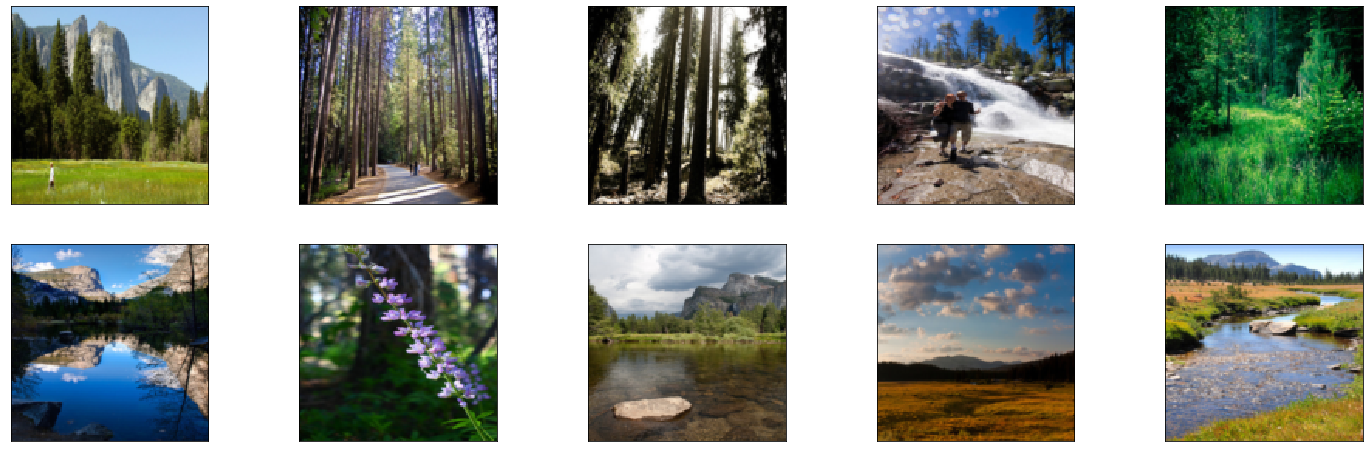

In [7]:
show_images(images_X)

**show winter images**

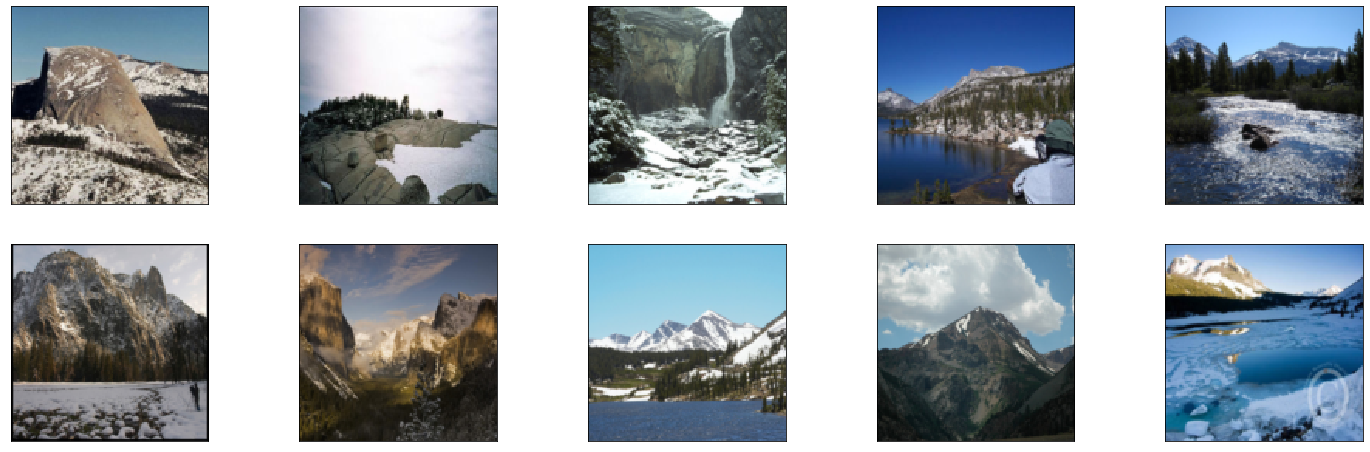

In [8]:
show_images(images_Y)

### Scaling images to required range

In [9]:
def scale_img(img, range=(-1, 1)):
    max, min = range
    return img * (max - min) + min

## Define the model

*Helper function for creating convolutional layers*

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=1,
         padding=0, instance_norm=True):
    '''
    Creates a convolutional layer, followed by an optional batch normalization layer
    '''
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                           padding, bias=False)
    layers.append(conv_layer)
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    
    return nn.Sequential(*layers)

Helper function for creating fractionally strided convolution layers

In [11]:
def frac_conv(in_channels, out_channels, kernel_size, stride=2,
              padding=1, output_padding=1, instance_norm=True):
    '''
    Creates a fractionally strided convolutional layer, followed by an optional 
    instance normalization layer
    '''
    layers = []
    frac_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
    layers.append(frac_conv_layer)
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### Generator

**Residual Block**

In [12]:
class ResBlock(nn.Module):
    '''
    Defines a residual network layer
    '''
    def __init__(self, n_channels):
        super().__init__()
        
        # reflection padding is used instead of zero padding
        self.ref_pad = nn.ReflectionPad2d(1)
        self.conv1 = conv(n_channels, n_channels, kernel_size=3, 
                                stride=1, padding=0)
        self.conv2 = conv(n_channels, n_channels, kernel_size=3, 
                                stride=1, padding=0)
    
    def forward(self, x):
        out = self.ref_pad(x)
        out = torch.relu(self.conv1(x))
        out = self.ref_pad(out)
        out = sefl.conv2(x)
        return x + out

In [13]:
class Generator(nn.Module):
    '''
    Defines the generator of a cycleGAN
    '''
    def __init__(self, n_res_blocks=6):
        super().__init__()
        
        model = []
        # initial convolutional block
        model += [nn.ReflectionPad2d(3),
                  conv(3, 64, kernel_size=7, stride=1, padding=0),
                  nn.ReLU(inplace=True)]
        
        # downsampling
        # add two conv layers to downsample the input image
        model += [conv(64, 128, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(inplace=True)]
        model += [conv(128, 256, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(inplace=True)]
        
        # residual blocks
        model += [ResBlock(256) for i in range(n_res_blocks)]

        # upsampling
        # add two upsampling layers to upsample to original size
        model += [frac_conv(256, 128, kernel_size=3, stride=2, padding=1, 
                            output_padding=1), 
                  nn.ReLU(inplace=True)]
        model += [frac_conv(128, 64, kernel_size=3, stride=2, padding=1, 
                            output_padding=1),
                  nn.ReLU(inplace=True)]
        
        # output layer
        model += [nn.ReflectionPad2d(3),
                  conv(64, 3, kernel_size=7, stride=1, padding=0),
                  nn.Tanh()]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):        
        return self.model(x)

## Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = []
        # first conv layer does not use instance norm
        model += [conv(3, 64, kernel_size=4, stride=2, padding=1, instance_norm=False),
                  nn.LeakyReLU(0.2, inplace=True)]
        # second conv layer
        model += [conv(64, 128, kernel_size=4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # third conv layer
        model += [conv(128, 256, kernel_size=4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # fourth conv layer
        model += [conv(256, 512, kernel_size=4, stride=1, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # FCN classifiaction layer
        model += [conv(512, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        out = self.model(x)
        # average pooling and flatenning
        out = F.avg_pool2d(out, out.size()[2:]).view(x.size()[0], -1)